# <font color='red'>1. Préparation de l'environnement </font>

Ci-dessous nous réalisons les imports de librairie nécessaire à notre travail et égal définir les précautions préalables.

In [53]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from statistics import mean
from time import *
from pandas.plotting import scatter_matrix
import seaborn as sbn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# stabilité du notebook d'une exécution à l'autre
random=np.random.default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# <font color='red'>2. Création des DataFrames </font>

Nous allons tout d'abord commencer par importer les CSV fournis dans le projet afin de réaliser la création des `DataFrames` correspondant.

In [2]:
def load_data(fileName):
    csv_path = os.path.join('../data', fileName)
    df = pd.read_csv(csv_path)
    return df

In [3]:
employee_survey_data = load_data('employee_survey_data.csv')
manager_survey_data = load_data('manager_survey_data.csv')
in_time = load_data('in_time.csv')
out_time = load_data('out_time.csv')
general_data = load_data('general_data.csv')

# <font color='red'>3. Choix des données </font>

## <font color='green'>3.1 Éthique </font>

Dans le cas de notre modèle et de l'utilisation de nos données il est important de déterminer éthiquement la conservation de certaines données ou non. 

Pour cela nous avons procédé à un brainstorming et à une lecture des recommendations de la CNIL pour conserver uniquement les données nécessaires et ne prêtant pas à une possible discrimination.

Voici la liste des données que nous ne souhaitons pas conserver pour notre modèle :

- **L’âge des employés (Age) :** Nous souhaitons rester dans la plus grande neutralité possible. Effectivement, l’âge ne doit pas nous permettre de définir si une personne est plus à même de quitter l’entreprise ou non. 
<br>

- **Le genre des employés (Gender) :** Le genre est une donnée non pertinente sur les critères qui pousserai à un turnover. Cette donnée pourrait être discriminante. 
<br>

- **Le statut marital (MaritalStatus) :** Cette donnée ne nous permettrai pas d’interpreter des critères cohérent concernant les Turn-over dans l’entreprise. Ce serai une surinterprétation des données fournis.

In [4]:
#remove the columns for ethic
general_dataset = general_data.copy() #copy the dataframe to avoid changing the original one
general_dataset.drop("Age", axis=1, inplace=True) 
general_dataset.drop("Gender", axis=1, inplace=True)
general_dataset.drop("MaritalStatus", axis=1, inplace=True)

## <font color='green'>3.2 Logique </font>

Il est également nécessaire de déterminer d'une manière logique les données utile à conserver ou non. 

Pour cela il suffit d'isoler dans un premier temps les colonnes de la table ***General_data***  ou le champs de valeur est égal à 1, c'est à dire que chaque données est la même.

Pour cela il suffit d'executer cette fonction afin de déterminer les champs répondant à cette condition :

In [5]:
for col in general_data.columns:
    value = general_data[col].nunique()
    value_of = general_data[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


On constate alors que :

- **EmployeeCount :** Cette colonne correspond à la présence ou non d'un employé dans l'entreprise dans les effectifs en 2015, on constate que chaque ligne du tableau est à 1 cela signifie donc que tous les employés présent dans les données était dans l'entreprise en 2015, il n'est donc pas intéressant de conserver cette donnée.
<br>

- **Over18 :** Cette colonne indique si l'age de l'employé est supérieure ou non à 18 ans, on constate que chaque ligne du tableau est à la valeur "Y" cela signifie donc que en 2015 chaque employé était majeur, il n'est donc pas intéressant de conserver cette donnée. 
<br>

- **StandardHours :** Cette colonne spécifie le nombre d'heure inscrite sur le contrat de l'employé, chaque ligne étant positionnée à 8h on en déduit que tous les employés disposait du même type de contrat en 2015. Il n'est donc pas intéressant de conserver cette donnée.

<div class="alert alert-block alert-info">
<b>Info:</b> Cette étude à également été effectuée sur les autres tables mais aucune valeur unique est apparue, nous conserverons alors toutes les données de celles-ci.
</div>


In [6]:
# remove the non revelent columns
general_dataset.drop("Over18", axis=1, inplace=True)
general_dataset.drop("EmployeeCount", axis=1, inplace=True)
general_dataset.drop("StandardHours", axis=1, inplace=True)

## <font color='green'>3.3 Conclusion </font>

Après avoir sélectionné les données à conserver en fonction de différents facteurs voici une liste exhaustive de celles conservées pour la réalisation de notre modèle :

###  <font color='blue'> General_data </font>

- **Attrition :** L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?
<br>

- **BusinessTravel :** A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)
<br>

- **DistanceFromHome :** Distance en km entre le logement de l'employé et l'entreprise.
<br>

- **Education : Niveau d'étude :** 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).
<br>

- **EducationField :** Domaine d'étude, matière principale
<br>

- **EmployeeId :** l'identifiant d'un employé
<br>

- **JobLevel :** Niveau hiérarchique dans l'entreprise de 1 à 5
<br>

- **JobRole :** Métier dans l'entreprise
<br>

- **MonthlyIncome :** Salaire brut en roupies par mois
<br>

- **NumCompaniesWorked :** Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.
<br>

- **PercentSalaryHike :** % d'augmentation du salaire en 2015.
<br>

- **StockOptionLevel :** Niveau d'investissement en actions de l'entreprise par le salarié.
<br>

- **TotalWorkingYears :** Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.
<br>

- **TrainingTimesLastYear :** Nombre de jours de formation en 2015
<br>

- **YearsAtCompany :** Ancienneté dans l'entreprise
<br>

- **YearsSinceLastPromotion :** Nombre d'années depuis la dernière augmentation individuelle
<br>

- **YearsWithCurrentManager :** Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

###  <font color='blue'> Employee_survey_data </font>

- **L'environnement de travail :** : noté 1 ("Faible"), 2 ("Moyen"), 3 ("Élevé") ou 4 ("Très élevé") : EnvironmentSatisfaction
<br>

- **Son travail :** noté de 1 à 4 comme précédemment : JobSatisfaction
<br>

- **Son équilibre entre vie professionnelle et vie privée :** noté 1 ("Mauvais"), 2 ("Satisfaisant"), 3 ("Très satisfaisant") ou 4 ("Excellent") : WorkLifeBalance

###  <font color='blue'> Manager_survey_data </font>

- **Une évaluation de son implication dans son travail :** notée 1 ('Faible'), 2 ("Moyenne"), 3 ("Importante") ou 4 ("Très importante") : JobInvolvement
<br>

- **Une évaluation de son niveau de performance annuel pour l'entreprise :** notée 1 ("Faible"), 2 ("Bon"), 3 ("Excellent") ou 4 ("Au delà des attentes") : PerformanceRating

###  <font color='blue'> In_Time et Out_Time </font>

Nous allons conserver toutes les données de badgeuse d'entrée et de sortie afin d'effectuer différents statistiques sur ces données.

# <font color='red'>4. Encodage </font>

## <font color='green'>4.1 Encodage binaire de l'attribut ***Attrition*** </font>
On convertit les données de l'attribut Attrition afin de rendre l'étude plus pertinente dans notre modéle, les valeurs 'Yes' et 'No' deviennent respectivement des 1 et des 0.

In [7]:
general_dataset['Attrition'] = general_dataset['Attrition'].map({'Yes': 1, 'No':0}) # convertir la colonne Attrition en 0 et 1

fir_column = general_dataset.pop('Attrition') # retirer la colonne Attrition
general_dataset.insert(0 ,'Attrition', fir_column) # la remettre en première colonne

## <font color='green'>4.2 One-Hot Encoding </font>
Nous allons créer des variables supplémentaires pour représenter chacun des catégories.
`BusinessTravel`, `Department`, `EducationField`, `JobRole`

In [8]:
onehot_encoder = OneHotEncoder(sparse=False) # sparse=False pour obtenir un tableau numpy (et non une matrice creuse)
data_encoded = onehot_encoder.fit_transform(general_dataset[['BusinessTravel', 'Department', 'EducationField', 'JobRole']])

def result_onehot(cat_one):
    tab = []
    for tableau in cat_one:
        for tableau2 in tableau:
            tab.append(tableau2)
    return tab

ids = [ i for i in range (1, (len(data_encoded)+1))]
data1hot = pd.DataFrame(data=data_encoded, dtype=np.int8, columns=result_onehot(onehot_encoder.categories_))
data1hot['EmployeeID'] = ids
data1hot.head(3)

c:\Users\oscar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Non-Travel,Travel_Frequently,Travel_Rarely,Human Resources,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,...,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,EmployeeID
0,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,2
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3


# <font color='red'>5. Calcul de moyennes sur les DataFrame In_Time et Out_Time</font>

## <font color='green'>5.1 Gestion des valeurs manquantes</font>

De nombreuses données sont manquantes parmis les horaires et sont représentées par la veleur **"NaN"**. 

Nous faisons le choix de supprimer une colonne contenant plus de 50% de données manquantes. Pour les autres données manquantes, nous les remplaçons par la date Unix qui correspond à une valeur nul en format date afin que ces données n'aient pas d'influence sur nos calculs.

In [9]:
#prepare time dataset
def dropNan(dataset):

    data = dataset.copy()
    colNames = [col for col in data.columns]

    percent= [round(100-((data[col].count()/len(data.index))*100),2) for col in data.columns]
    indexes = [index for index, value in enumerate(percent) if value > 50]

    for i in indexes:
        data.drop(colNames[i], axis=1, inplace=True)
        
    data.fillna("1970-01-01 00:00:00", inplace=True)
    
    return data

In [10]:
inTime_prep = dropNan(in_time)
outTime_prep = dropNan(out_time)
inTime_prep.head(3)

,Unnamed: 0,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,2015-01-15 10:01:24,...,1970-01-01 00:00:00,1970-01-01 00:00:00,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,2015-01-02 10:15:44,2015-01-05 10:21:05,1970-01-01 00:00:00,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,2015-01-15 09:37:57,...,2015-12-17 09:15:08,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,1970-01-01 00:00:00,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,2015-01-15 09:55:11,...,2015-12-17 09:53:17,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39


On constate bien que notre tableau ne contient plus aucune valeure NaN et que celles-ci ont été remplacées par la valeure UNIX ***"1970-01-01 00:00:00"***

## <font color='green'>5.2 Calculs des moyennes</font>

Dans notre modèle il n'est pas pertient d'utiliser les valeurs d'heures d'entrée et de sortie telle quelle, l'utilisation de celles -ci ne permettrai pas de faire de corélation entre plusieurs données.

Nous avons donc décider de réaliser 3 moyennes différentes :

- `Average_Worktime` : Correspond au temps de travail moyen de chaque employé pour l'année 2015
<br>

- `Average_In_Time` : Correspond aux heures moyennes d'arrivés par employé pour l'année 2015
<br>

- `Average_Out_Time` : Correspond aux heures moyennes de départs par employé pour l'année 2015

In [11]:
def sec(date):
    getlast = ((str(date))[-8:]).replace(":", "")
    time = (int(getlast[4:6])) + ((int(getlast[2:4])) * 60) + (int(getlast[0:2])) * 3600
    return time

def average_In_Out_Time(time):
    tabs = []
    for row in range(0, len(time)):
        means = [sec(dt.datetime.strptime(time.iloc[row, col], "%Y-%m-%d %H:%M:%S")) for col in range(1, len(time.columns))]
        means_convert = round(((int((round(mean(means), 0)))) / 3600),2)
        tabs += [means_convert]
    return tabs
    
def average_worktime(out_time, in_time) :
    tab = []
    for lines in range(0, len(out_time)):
        worktime = [(((dt.datetime.strptime(out_time.iloc[lines,col], "%Y-%m-%d %H:%M:%S")) - (dt.datetime.strptime(in_time.iloc[lines,col], "%Y-%m-%d %H:%M:%S"))).total_seconds()) for col in range(1, len(out_time.columns))]
        worktime_convert = round(((int((round(mean(worktime), 0)))) / 3600),2)
        tab += [worktime_convert]
    return tab

In [12]:
d = {'EmployeeID': inTime_prep.iloc[:, 0], 'Average_Worktime': average_worktime(outTime_prep, inTime_prep), 'Average_In_Time': average_In_Out_Time(inTime_prep), 'Average_Out_Time': average_In_Out_Time(outTime_prep)}
wortime_employee = pd.DataFrame(data=d)
wortime_employee.head(3)

,EmployeeID,Average_Worktime,Average_In_Time,Average_Out_Time
0,1,6.87,9.32,16.19
1,2,7.32,9.47,16.78
2,3,6.82,9.74,16.56


On peut alors observer notre DataFrame ci-dessus avec les différentes moyennes.

# <font color='red'>6. Fusion des tables</font>
Nous allons fusionner les dataframes selon l'id de l'employé pour inclure les evaluations d'impliquation, les évaluations de niveaux de performance et les données concernant les horaires.

In [13]:
#merge the dataframes
survey_dataset = pd.merge(employee_survey_data, manager_survey_data, on='EmployeeID')
dataset_with_survey = pd.merge(general_dataset, survey_dataset, on='EmployeeID')
Dataset = pd.merge(dataset_with_survey, wortime_employee, on='EmployeeID')
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average_Worktime,Average_In_Time,Average_Out_Time
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,0,0,3.0,4.0,2.0,3,3,6.87,9.32,16.19
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,1,4,3.0,2.0,4.0,2,4,7.32,9.47,16.78
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,0,3,2.0,2.0,1.0,3,3,6.82,9.74,16.56


# <font color='red'>7. Nettoyage des données</font>

Nous allons supprimer les valeurs manquantes.
Nous constatons alors qu'il y a des valeurs manquantes pour 110 employés.

In [14]:
sample_incomplete_rows = Dataset[Dataset.isnull().any(axis=1)]
len(sample_incomplete_rows.index)

110

Cela correspond à moins de 3% de nos valeurs.

Nous faisons donc le choix de supprimer les lignes contenant des valeurs manquantes.

In [15]:
(len(sample_incomplete_rows.index)/len(Dataset.index))*100

2.494331065759637

In [16]:
Dataset.dropna(inplace=True)
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average_Worktime,Average_In_Time,Average_Out_Time
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,0,0,3.0,4.0,2.0,3,3,6.87,9.32,16.19
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,1,4,3.0,2.0,4.0,2,4,7.32,9.47,16.78
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,0,3,2.0,2.0,1.0,3,3,6.82,9.74,16.56


# <font color='red'>8. Corrélation</font>

## <font color='green'>8.1 Matrice de corrélation</font>



In [17]:
corrmatrix = Dataset.corr()
corrmatrix['Attrition']

C:\Users\oscar\AppData\Local\Temp\ipykernel_16816\4077177633.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmatrix = Dataset.corr()


Attrition                  1.000000
DistanceFromHome          -0.008314
Education                 -0.015237
EmployeeID                -0.001707
JobLevel                  -0.014587
MonthlyIncome             -0.032629
NumCompaniesWorked         0.043911
PercentSalaryHike          0.034425
StockOptionLevel          -0.007971
TotalWorkingYears         -0.168637
TrainingTimesLastYear     -0.046239
YearsAtCompany            -0.133612
YearsSinceLastPromotion   -0.029931
YearsWithCurrManager      -0.155420
EnvironmentSatisfaction   -0.103485
JobSatisfaction           -0.103098
WorkLifeBalance           -0.059817
JobInvolvement            -0.014705
PerformanceRating          0.026262
Average_Worktime           0.195118
Average_In_Time            0.039340
Average_Out_Time           0.188202
Name: Attrition, dtype: float64

D'après la matrice de corrélation ci dessus, nous pouvons déduire quelque faits intéressant pour notre étude : 
- **Les variables les plus fortement corrélées négativement avec `Attrition`** sont `TotalWorkingYears` *(-0,17)*, `YearsAtCompany` *(-0,13)*, `YearsWithCurrManager` *(-0,16)*. Cela nous indique que plus les employés travaillent longtemps dans l'entreprise, moins ils sont susceptibles de quitter l'entreprise. Il en est de même pour les employés ayant travaillé avec leur manager actuel depuis longtemps.

- D'autres variables ont également une corrélation négative significative avec `Attrition`, comme `EnvironmentSatisfaction` *(0,10)* et `JobSatisfaction` *(-0,10)*, indiquant que les employés qui sont plus satisfaits de leur environnement et de leur travail sont moins susceptibles de quitter l'entreprise.

- **Les variables ayant une corrélation positive significative avec `Attrition`** incluent `Average_Worktime` *(0,20)* et `Average_Out_Time` *(0,19)*, suggérant que les employés qui travaillent plus longtemps sont plus susceptibles de quitter l'entreprise.

> Corrélation ne signifie pas toujours causalité. Il est donc nécessaire **d'analyser plus en profondeur** les variables ayant une forte corrélation avec l'attrition pour comprendre les facteurs qui influencent réellement les employés à quitter l'entreprise.

Faire petite explication sur corr entre attribut

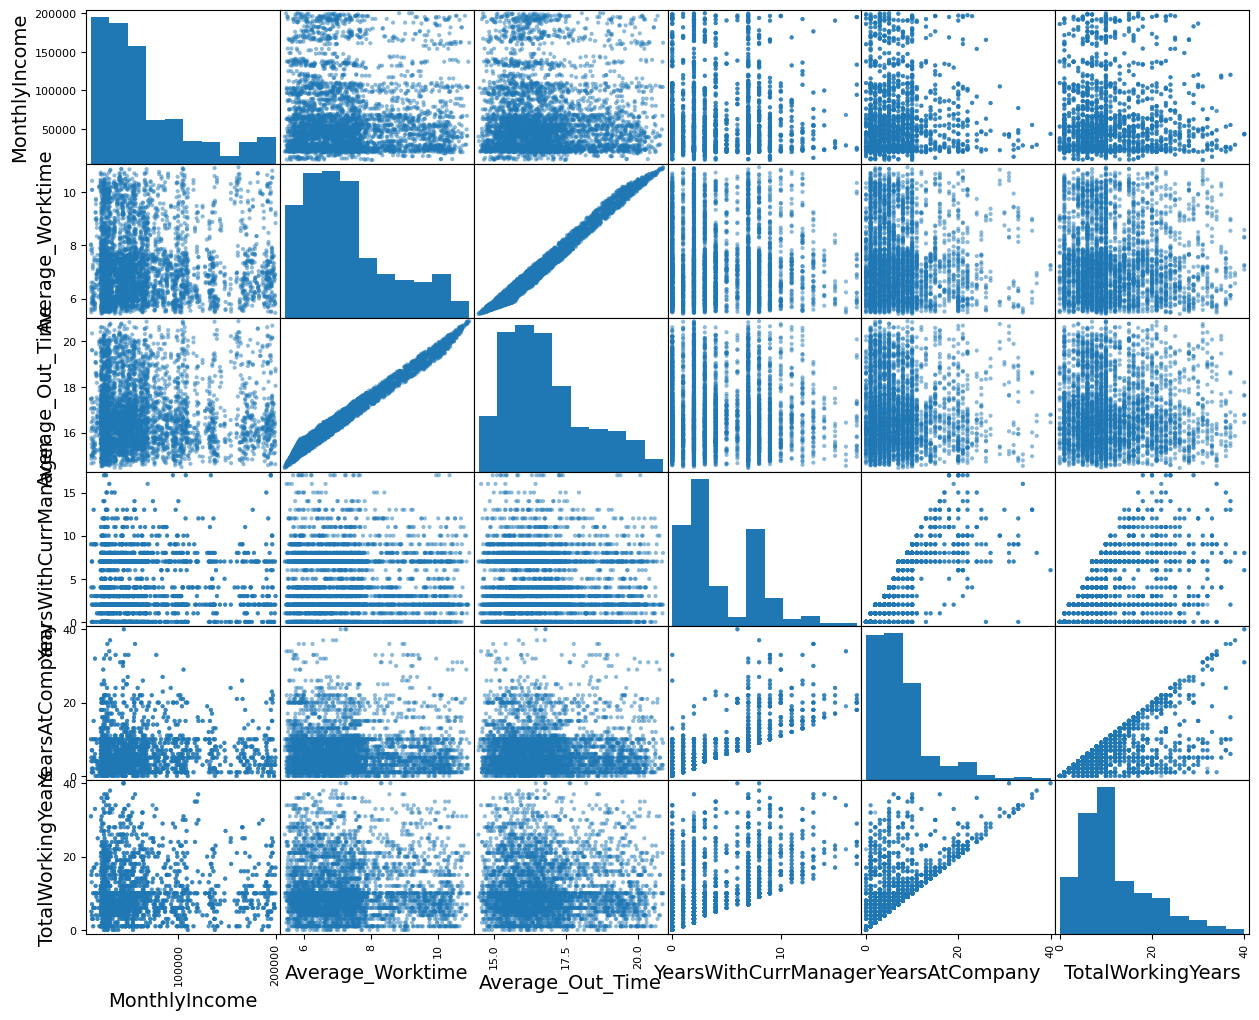

In [18]:
attributes = ["MonthlyIncome", "Average_Worktime", "Average_Out_Time", "YearsWithCurrManager", "YearsAtCompany", "TotalWorkingYears"]
scat_matrix = scatter_matrix(Dataset[attributes], figsize=(15, 12))

Nous ne pouvons rien déduire de notre matrice de corrélation. Cela peut être dû au fait que ces variables ne sont pas liées les unes aux autres ou que la relation entre elles est complexe et non linéaire.
<br> 
Il sera donc nécessaire de faire une analyse plus détaillé et de faire des tests statistiques pour vraiment déterminer s'il y a des relations significatives entre les variables étudiées.

## <font color='green'>8.2 Calcul du taux de turnover</font>


16.162790697674417


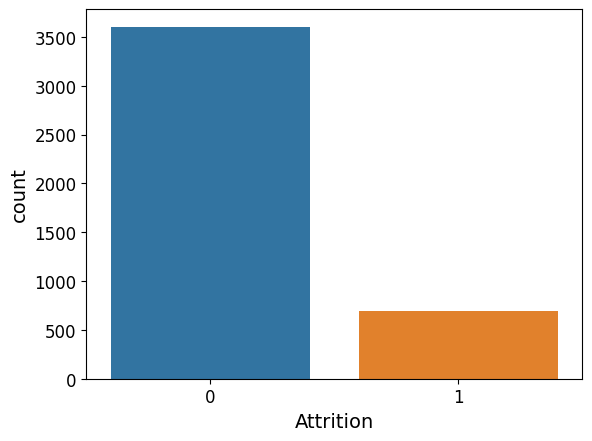

In [19]:
percent = ((Dataset['Attrition'] == 1).sum() / Dataset['Attrition'].shape[0]) * 100
print(percent)
sbn.countplot(x='Attrition', data=Dataset)
plt.show()

On retrouve bien un turnover de 16% pour l'entreprise HumanForYou

## <font color='green'>8.3 Visualisation de la relation entre les variables discrètes et l'attrition </font>

Dans cette partie de l'analyse, nous allons explorer la relation entre l'attrition et les variables discrètes telles que l'éducation, les déplacements professionnels, le département, le rôle du poste, l'implication dans le travail, la satisfaction environnementale, la satisfaction professionnelle et l'équilibre entre vie professionnelle et personnelle. Nous allons utiliser des histogrammes pour visualiser la proportion d'employés ayant quitté l'entreprise en fonction de ces variables.

In [20]:
def plot_hist(column, df):

    x_name = column
    y_name = 'Attrition'

    temp_data = (df
     .groupby(x_name)[y_name]
     .value_counts(normalize=True)
     .mul(100)
     .rename('percent')
     .reset_index())

    sbn.set_context('talk', font_scale = 1)
    catp = sbn.catplot(data=temp_data, x=x_name, y='percent', hue='Attrition', kind='bar', height = 4, aspect = 2, legend_out=True, margin_titles=True)

    catp.set_xticklabels(rotation=30, fontsize=15, horizontalalignment='right',)

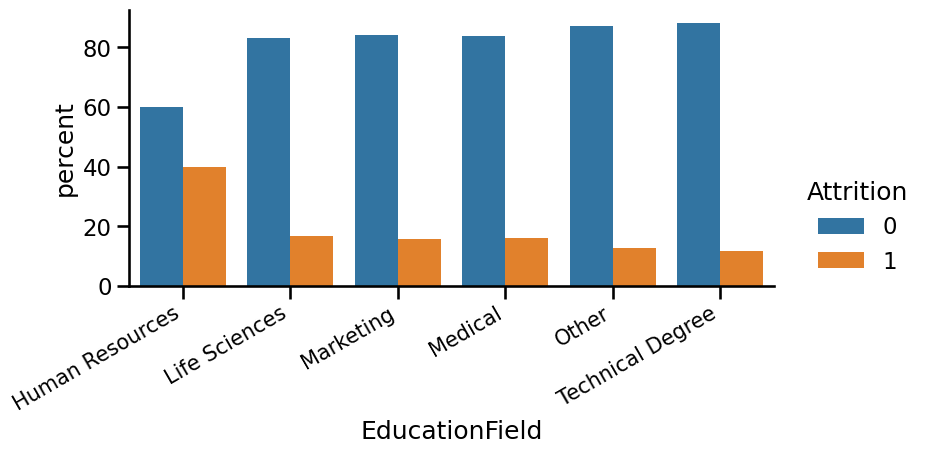

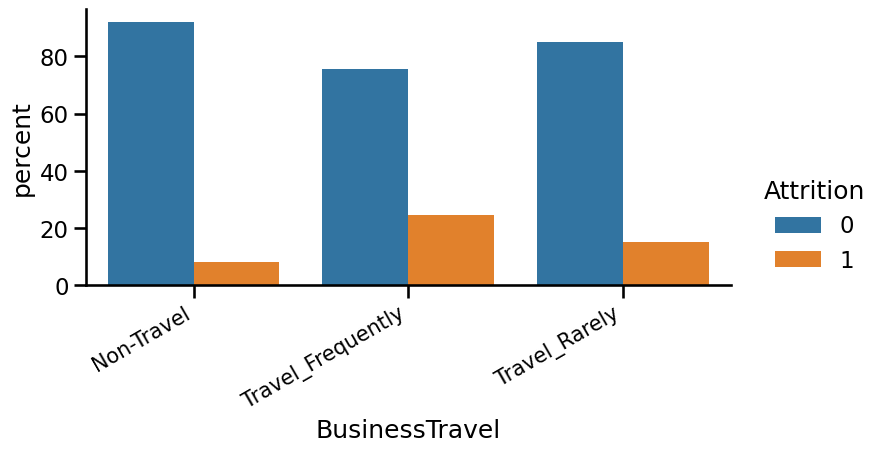

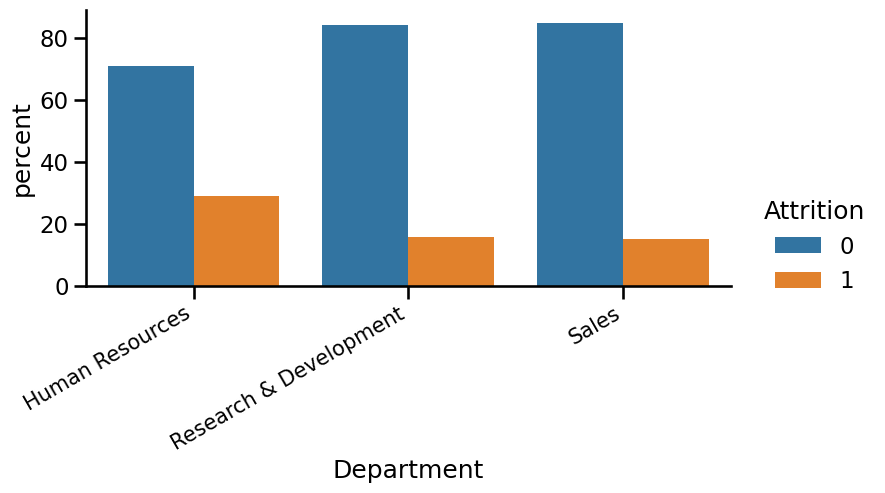

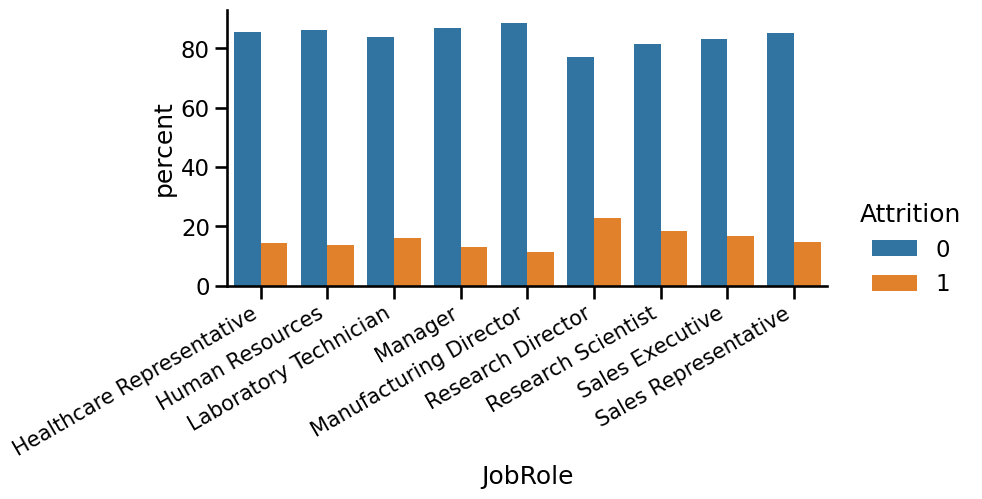

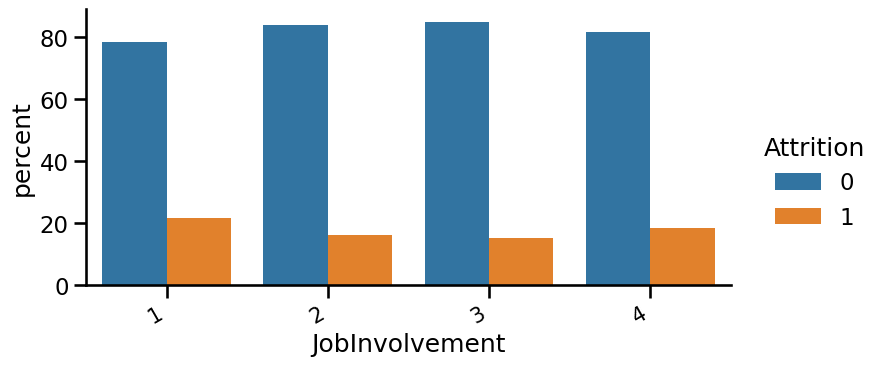

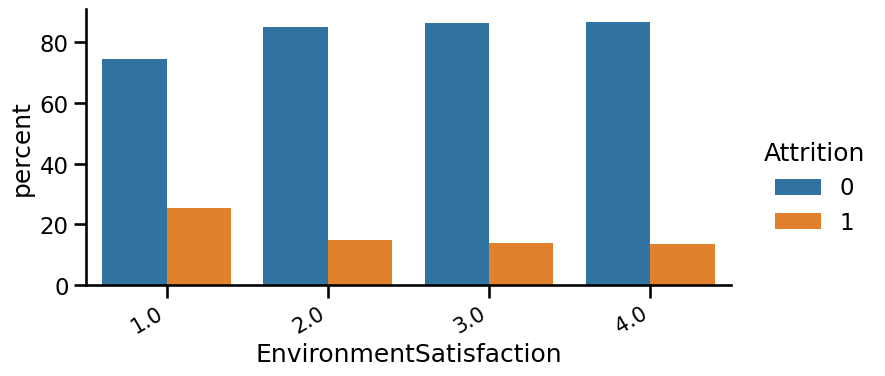

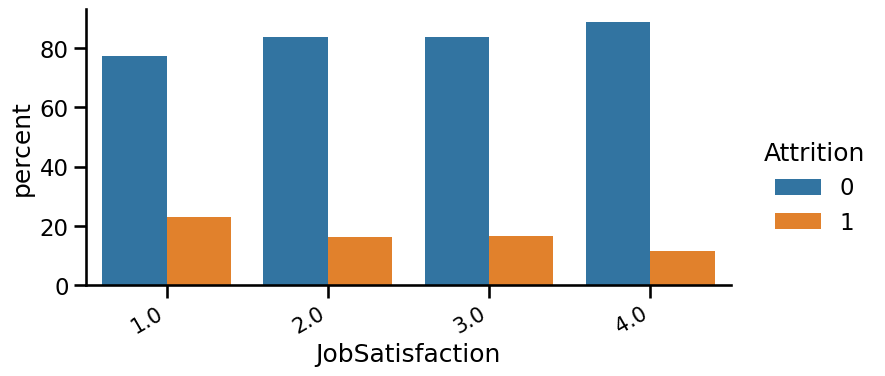

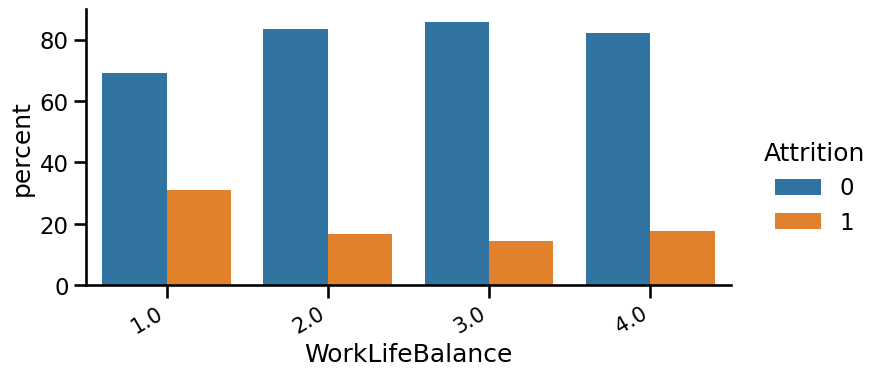

In [21]:
colsDis = ['EducationField', 'BusinessTravel', 'Department', 'JobRole', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for col in colsDis:
    plot_hist(col, Dataset)

**Interprétation de ces graphiques** : 

- `EducationField` : On remarque tout d'abord taux de turnover plus important dans le domaine des ressources humaines.
- `BusinessTravel` : Plus un employé sera amené à faire des voyages d'affaires plus il y'aura un risque de turnover.
- `Department` : On remarque encore une fois un plus important taux de turnover pour les ressources humaines.
- `JobRole` : Nous constatons que les directeurs de recherche possèdent un taux de turnover plus important.
- `JobInvolvement` : On constate qu'une note d'implication plus basse amène à un taux de turnover plus élevé.
- `EnvironmentSatisfaction` : Si un employé est satisfait par son environnement de travail, il sera moins amené à partir.
- `JobSatisfaction` : Si un employé est satisfait par son travail, il sera également moins amené à partir.
- `WorkLifeBalance` : Un mauvaise équilibre entre la vie professionnelle et personnelle d'un employé amène un taux de turnover plus important.

En analysant la relation entre les variables discrètes et l'attrition, nous avons pu observer que certains facteurs ont un impact significatif sur le taux de turnover des employés, tels que le domaine d'éducation, les voyages d'affaires, le département et le poste occupé, ainsi que l'implication, la satisfaction de l'environnement et du travail, et l'équilibre entre la vie professionnelle et personnelle. 
<br>
Ces conclusions peuvent aider l'entreprise à prendre des mesures préventives pour réduire le taux de turnover et améliorer la rétention des employés.


## <font color='green'>8.4 Visualisation de la relation entre les variables continues et l'attrition </font>

Après avoir examiné la relation entre les variables discrètes et l'attrition, nous allons maintenant étudier la relation entre les variables continues et l'attrition. Nous allons visualiser cette relation à travers des histogrammes empilés pour chaque variable continue.

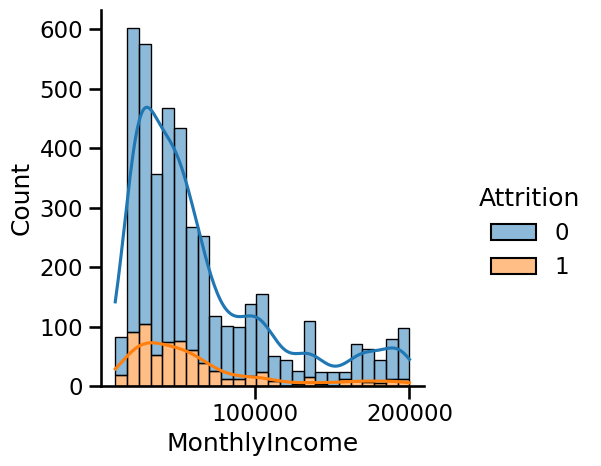

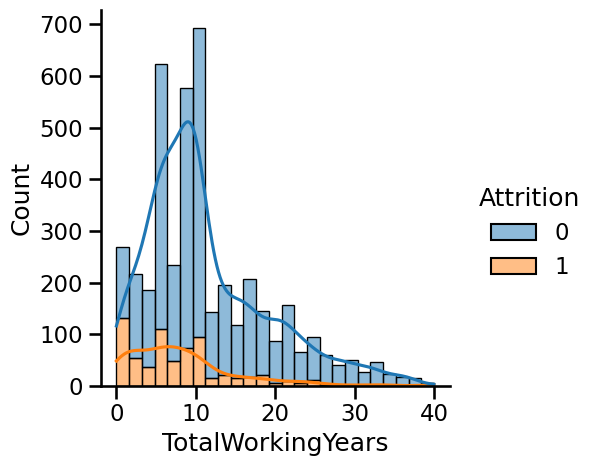

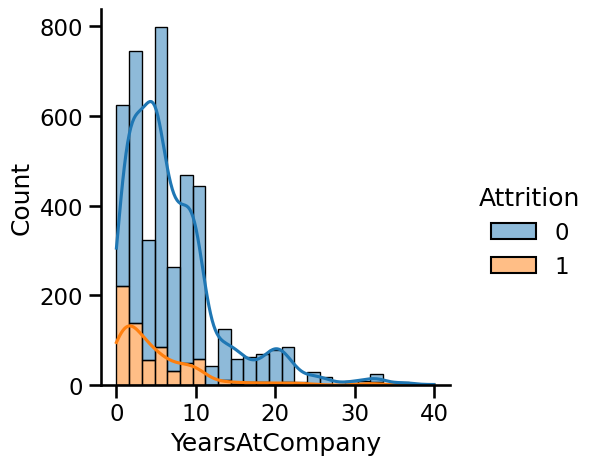

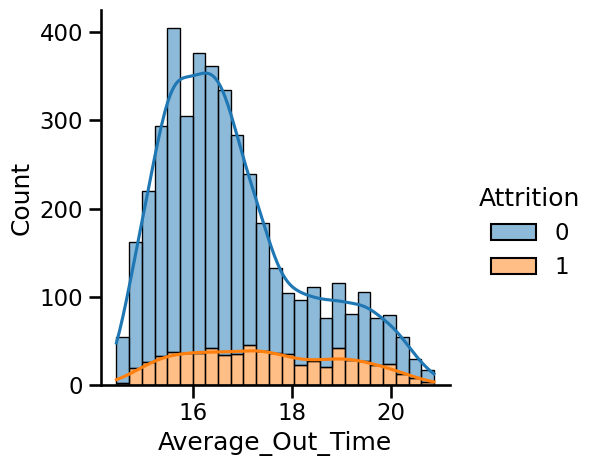

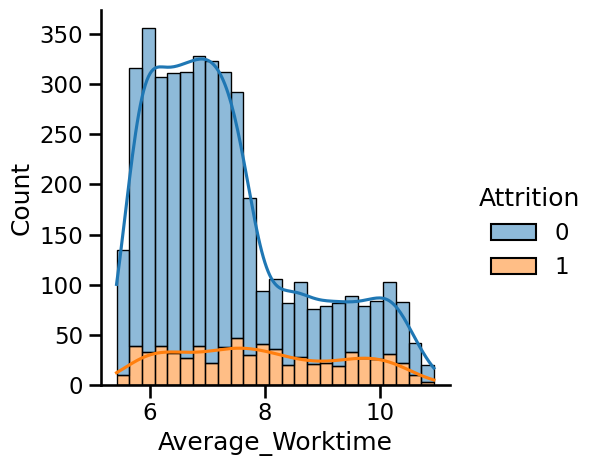

In [22]:
colsCon = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'Average_Out_Time', 'Average_Worktime']

for col in colsCon:
    sbn.displot(data=Dataset, x=col, hue="Attrition", multiple="stack", kde=True, bins=25)
    plt.show()

En analysant ces graphiques, on peut observer des tendances intéressantes pour chaque variable :

- La distribution de `MonthlyIncome` montre que les employés ayant quitté l'entreprise ont tendance à **gagner moins** que ceux qui sont restés.
- La distribution de `TotalWorkingYears` montre que les employés ayant quitté l'entreprise ont tendance à **avoir moins d'années d'expérience professionnelle total**e.
- La distribution de `YearsAtCompany` montre que les employés ayant quitté l'entreprise ont tendance à **avoir travaillé moins longtemps dans l'entreprise**.
- Les distributions de `Average_Out_Time` et `Average_Worktime` montrent que les employés ayant quitté l'entreprise ont tendance à **travailler plus longtemps**.

> Ces tendances suggèrent que la **rémunération**, **l'expérience professionnelle totale**, **la durée de travail dans l'entreprise** et **la durée de travail quotidienne** sont des facteurs qui peuvent influencer la décision d'un employé de quitter l'entreprise.

# <font color='red'>9. Prétraitement des données pour les modèles de Machine Learning</font>


Le non-scaling des variables peut conduire à une mauvaise performance du modèle, notamment si les variables sont sur des échelles très différentes ou si l'algorithme utilisé est sensible aux différences d'échelle (ex. `MonthlyIncome` entre 10 000 et 200 000 alors que `JobLevel` entre 0 et 5).


Nous avons à notre disposition plusieurs stratégies:
* Echantillonage stratifié : L'échantillonnage stratifié consiste à diviser la population en groupes homogènes puis à prélever un échantillon représentatif en proportion de la taille de chaque groupe.

* Feature scaling : Le feature scaling est une technique importante dans le prétraitement des données pour les modèles d'apprentissage automatique, car elle permet de mettre les variables à la même échelle, ce qui facilite leur comparaison et leur traitement par les algorithmes.

## <font color='green'>9.1 Exemple d'échantillonage stratifié</font>


On constate que la valeur maximale de `MonthlyIncome` est d'environ ***200 000*** il sera donc intéressant de diviser cette catégorie en 10 parties. 

Nous devrons donc diviser nos valeurs par ***20 000***

<AxesSubplot: >

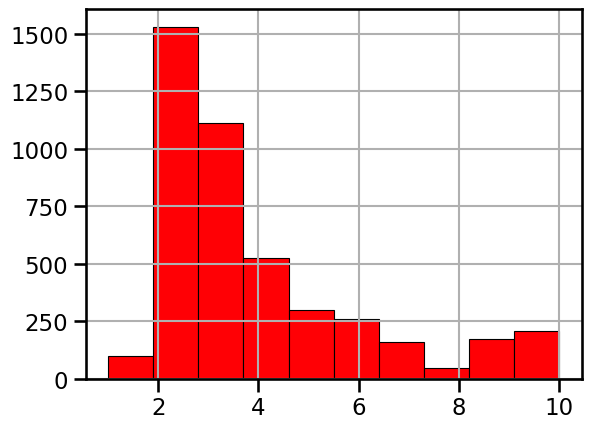

In [23]:
general_dataset["MonthlyIncome_cat"] = np.ceil(general_dataset["MonthlyIncome"]/20000)

general_dataset["MonthlyIncome_cat"].hist(facecolor = '#ff0005', edgecolor='#000000', linewidth=0.8, bins=10)

## <font color='green'>9.1 Feature scaling</font>

Les stratégies de feature scaling sont : _min-max scaling_ et _standardization_.
* min-max scaling : _mappe_ [min,max] sur[0,1] ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))
* standardization : _mappe_ la moyenne sur zero avec variance unitaire. ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

La deuxième option est moins sensible aux [_valeurs aberrantes_](https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante).


In [24]:
#on recupere les colonnes numériques du dataset
Dataset_num = Dataset.select_dtypes(include=[np.number])
Dataset_num.drop("Attrition", axis=1, inplace=True)

Dataset_num.head(3)

,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average_Worktime,Average_In_Time,Average_Out_Time
0,6,2,1,1,131160,1.0,11,0,1.0,6,...,0,0,3.0,4.0,2.0,3,3,6.87,9.32,16.19
1,10,1,2,1,41890,0.0,23,1,6.0,3,...,1,4,3.0,2.0,4.0,2,4,7.32,9.47,16.78
2,17,4,3,4,193280,1.0,15,3,5.0,2,...,0,3,2.0,2.0,1.0,3,3,6.82,9.74,16.56


In [25]:
scaler = StandardScaler()
scaler.fit(Dataset_num)
DatasetScaled = scaler.transform(Dataset_num)

DatasetScaled.shape

(4300, 21)

In [26]:
DatasetScaled = pd.DataFrame(data=DatasetScaled)
ids = [ i for i in range (1, (len(DatasetScaled)+1))]
DatasetScaled['EmployeeID'] = ids
DatasetScaled

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,EmployeeID
0,-0.394993,-0.891282,-1.738009,-0.964277,1.405193,-0.677226,-1.149725,-0.931939,-1.320442,2.483520,...,-1.159067,0.252403,1.157359,-1.075518,0.38155,-0.426577,-0.335107,-0.762925,-0.430959,1
1,0.099071,-1.867220,-1.737223,-0.964277,-0.492557,-1.077952,2.126858,0.239797,-0.678523,0.157924,...,-0.037179,0.252403,-0.657940,1.750469,-1.02554,2.344242,0.002715,-0.084746,-0.017542,2
2,0.963683,1.060595,-1.736437,1.746964,2.725773,-0.677226,-0.057531,2.583269,-0.806907,-0.617274,...,-0.317651,-0.661946,-0.657940,-2.488512,0.38155,-0.426577,-0.372643,1.135975,-0.171698,3
3,-0.889057,2.036534,-1.735651,0.843217,0.385846,0.124225,-1.149725,2.583269,0.220163,1.708321,...,0.243293,1.166752,1.157359,0.337475,-1.02554,-0.426577,-0.395165,-0.310806,-0.416945,4
4,0.099071,-1.867220,-1.734864,-0.964277,-0.885202,0.524950,-0.876677,1.411533,-0.293372,-0.617274,...,-0.037179,1.166752,-1.565590,0.337475,0.38155,-0.426577,0.423116,1.588095,0.641122,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,-0.642025,0.084657,1.724337,-0.060530,-0.630737,-0.677226,0.761615,-0.931939,-0.678523,-0.617274,...,0.243293,0.252403,1.157359,0.337475,-1.02554,-0.426577,-0.147428,1.226399,0.052529,4296
4296,-0.518509,1.060595,1.725123,-0.964277,-0.101400,0.124225,0.488567,0.239797,-0.164988,1.708321,...,-0.598123,1.166752,-1.565590,0.337475,0.38155,-0.426577,0.753431,1.316823,0.907390,4297
4297,-0.889057,1.060595,1.725910,-0.964277,-0.813561,-0.276501,-0.057531,-0.931939,-0.164988,-0.617274,...,-0.598123,1.166752,1.157359,0.337475,-1.02554,-0.426577,-1.063302,0.864704,-0.858390,4298
4298,1.951811,-0.891282,1.726696,-0.060530,-0.596086,-1.077952,1.307712,-0.931939,-0.806907,0.933123,...,-0.598123,-1.576295,0.249709,0.337475,0.38155,2.344242,-0.124907,-1.034196,-0.276803,4299


Nous utiliserons `DatasetScaled` comme notre dataset final pour nos modèles de Machine Learning.

In [27]:
#on merge les col 1hot encoded
DatasetPrep = pd.merge(DatasetScaled, data1hot, on='EmployeeID')

attri = [i for i in Dataset['Attrition']]
DatasetPrep['Attrition'] = attri

DatasetPrep.drop("EmployeeID", axis=1, inplace=True)
DatasetPrep.columns = DatasetPrep.columns.astype(str)
DatasetPrep.head(3)

,0,1,2,3,4,5,6,7,8,9,...,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Attrition
0,-0.394993,-0.891282,-1.738009,-0.964277,1.405193,-0.677226,-1.149725,-0.931939,-1.320442,2.483520,...,1,0,0,0,0,0,0,0,0,0
1,0.099071,-1.867220,-1.737223,-0.964277,-0.492557,-1.077952,2.126858,0.239797,-0.678523,0.157924,...,0,0,0,0,0,0,1,0,0,1
2,0.963683,1.060595,-1.736437,1.746964,2.725773,-0.677226,-0.057531,2.583269,-0.806907,-0.617274,...,0,0,0,0,0,0,0,1,0,0


# <font color='red'>10. Pipeline de transformation</font>

Dans cette partie, nous avons créé une classe Transformer qui nous permet de réaliser les différentes transformations sur les données en utilisant la méthode `fit_transform` des pipelines de Scikit-learn. Cette classe nous permet de réaliser les étapes suivantes :

- Remplacement des valeurs de la colonne `Attrition` par `1` ou `0` (au lieu de `Yes` ou `No`) pour faciliter les traitements ultérieurs.
- Suppression des colonnes `Age`, `Gender` et `MaritalStatus` qui ne sont pas pertinentes pour notre étude et sont également éthiquement discutables.
- Suppression des colonnes `Over18`, `EmployeeCount` et `StandardHours` qui ont une seule valeur constante et qui ne sont donc pas utiles pour l'analyse.
<br>

Ensuite, nous avons créé un pipeline complet `general_dataset_pipeline` qui englobe la classe `Transformer` que nous venons de créer ainsi que le scaler `StandardScaler` qui permet de standardiser les données.
<br>

Enfin, nous avons créé un `ColumnTransformer` qui permet d'appliquer le pipeline `general_dataset_pipeline` sur les attributs numériques du dataset et d'encoder en one-hot encoding les colonnes catégorielles (`BusinessTravel`, `Department`, `EducationField` et `JobRole`).

In [28]:
from sklearn.base import TransformerMixin, BaseEstimator

class Transfomer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Attrition
        X_copy["Attrition"] = X_copy["Attrition"].map({'Yes': 1, 'No':0})
        fir_column = general_dataset.pop('Attrition') # retirer la colonne Attrition
        general_dataset.insert(0 ,'Attrition', fir_column) # la remettre en première colonne

        #ethic
        X_copy.drop("Age", axis=1, inplace=True) 
        X_copy.drop("Gender", axis=1, inplace=True)
        X_copy.drop("MaritalStatus", axis=1, inplace=True)

        #useless data
        X_copy.drop("Over18", axis=1, inplace=True)
        X_copy.drop("EmployeeCount", axis=1, inplace=True)
        X_copy.drop("StandardHours", axis=1, inplace=True)
    
        return X_copy.values

In [29]:
onehotCol = ['BusinessTravel', 'Department', 'EducationField', 'JobRole']

general_dataset_pipeline = Pipeline([
    ('Transfom', Transfomer()),
    ('scaler', StandardScaler()),
])

In [30]:
onehotCol = ['BusinessTravel', 'Department', 'EducationField', 'JobRole']

attribs = [item for item in list(general_data) if item not in onehotCol]

full_pipeline = ColumnTransformer([
    ("pipeDataset", general_dataset_pipeline, attribs),
    ('onehot_encoder', OneHotEncoder(sparse=False), onehotCol),
])

transformed_data = full_pipeline.fit_transform(general_data)
transformed_data.shape

c:\Users\oscar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(4410, 35)

Finalement, on obtient un nouveau jeu de données prêt à être utilisé dans des modèles de machine learning.

# <font color='red'>11. Split</font>

On effectue une séparation de notre jeu de données en deux sous ensembles :
- Un jeu de données **d'entraînement**
- Un jeu de données **test**

Nous utilisons la fonction `train_test_split` du module `model_selection` de Scikit-learn pour effectuer cette séparation.

Nous avons défini notre variable cible Y comme étant la colonne `Attrition` de notre jeu de données, puis nous l'avons retirée de notre ensemble de données X.

La fonction `train_test_split` divise ensuite l'ensemble X et Y en un ensemble d'entraînement (`X_train` et `y_train`) et un ensemble de test (`X_test` et `y_test`). 

Ici, nous avons choisi de conserver 20% de jeu de données **test** et 80% pour notre jeu de données **d'entraînement**. Nous avons également défini `random_state` à 42 pour garantir la reproductibilité des résultats.

In [31]:
from sklearn.model_selection import train_test_split

Y = DatasetPrep['Attrition']

DatasetPrepCopy = DatasetPrep.copy()
DatasetPrepCopy.drop("Attrition", axis=1, inplace=True)

X = DatasetPrepCopy

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [33]:
print(y_test.to_numpy()[3])
logisticRegr.predict(X_test.to_numpy()[3].reshape(1, -1))

1


c:\Users\oscar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [55]:
y_scores_reg = cross_val_predict(logisticRegr, x_train, y_train, cv=3, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_test, y_scores_reg)

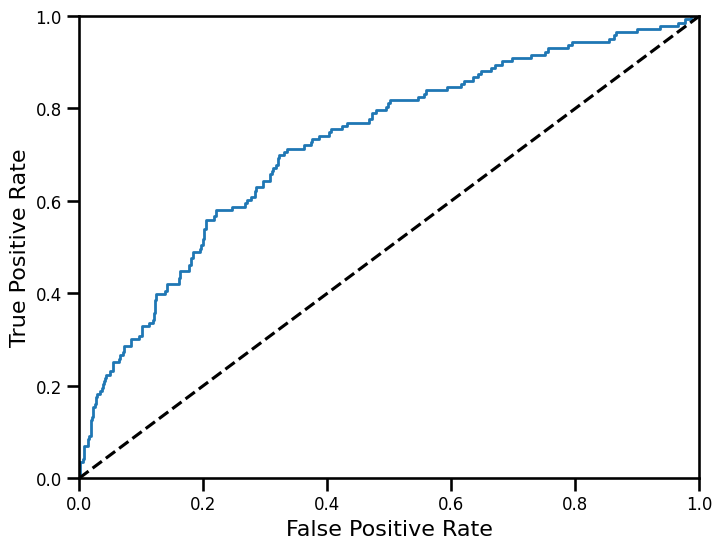

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [58]:
round(roc_auc_score(y_train, y_scores_reg),2)

ValueError: Found input variables with inconsistent numbers of samples: [3440, 860]

In [44]:
param_grid = [
    # essaye 12 (3×4) combinaisons des hyperparametres
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # puis essaye 6 (2×3) combinaisons avec bootstrap à False (True étant la valeur par défaut)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_clf = RandomForestClassifier(random_state=42)

# 5 sous-jeux de cross-val, ça fait en tout (12+6)*5=90 tours d'entraînement 
grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [39]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [40]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=10,
                       random_state=42)

In [45]:
forest_clf_best = RandomForestClassifier(bootstrap=False, max_features=4, random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')

In [46]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

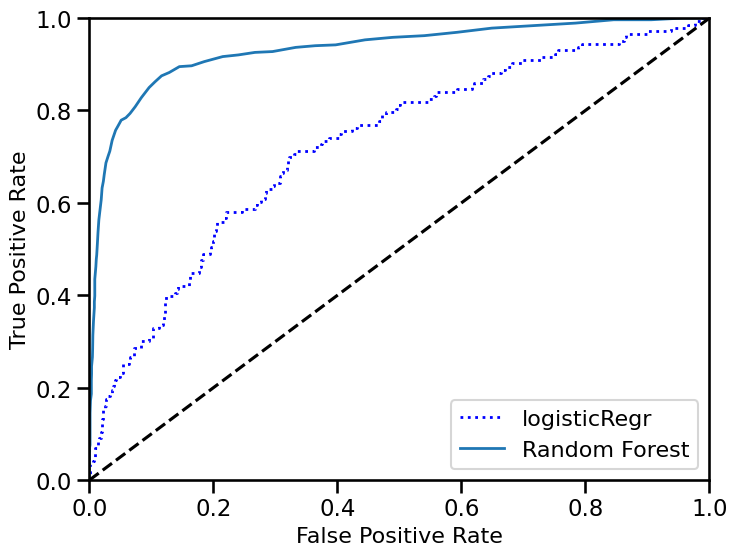

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="logisticRegr")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [49]:
roc_auc_score(y_train, y_scores_forest)

NameError: name 'roc_auc_score' is not defined

In [43]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.0555918 , 0.03130969, 0.03078298, 0.02860191, 0.07954915,
       0.0429392 , 0.04154578, 0.02521371, 0.08246385, 0.03175245,
       0.05566887, 0.03900287, 0.04735902, 0.03535443, 0.03061023,
       0.02822596, 0.02625793, 0.00800129, 0.0784458 , 0.03354182,
       0.07443728, 0.00461082, 0.00460587, 0.00457735, 0.00168495,
       0.00526808, 0.00587296, 0.00043146, 0.00769709, 0.00266401,
       0.00703679, 0.00378083, 0.00495089, 0.00383768, 0.00206911,
       0.00604896, 0.00335447, 0.00477056, 0.00440094, 0.00664318,
       0.00612491, 0.00291305])